# Assignment 7

I think it needed a redo rather than straight from hand on because we've skipped training data so it won't be accurate<br>
and it's hard to fix that in there so I reorganized the whole thing

`Assignment details: `

Develop an Optuna optimized model that accounts for both title and body text.

- Show that you can parallelize optuna process and use all cpus. (1 point)
- Fine-tune the model to achieve the highest cross-validation (CV) accuracy:
    - Final f1 > 0.80 will earn 1 point
    - Final f1 <= 0.80 will earn 0.5 point
- Showcase enhancements in data preprocessing techniques. (1 point)
- Explain how you improved hyperparameter tuning. (1 point)
- Finally, integrate the best-configured model into a Flask application. (1 point)

---
Firstly we start preprocessing setups

We're using a translation table to remove unwanted characters such as punctuation and non-breaking spaces.

Remove stopwords

Stemming words to their root form


In [1]:
import re
import string
import logging
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from multiprocessing import Pool

# Precompile translation table
TRANSLATION_TABLE = str.maketrans('', '', '!"#$%&\'()*+,.<=>?@[]^`{|}~' + u'\xa0')

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

def preprocess(text, stopwords_set, ps):
    words = text.split()
    words = [w for w in words if w.lower() not in stopwords_set]
    words = [ps.stem(w) for w in words]
    processed_text = ' '.join(words)
    logging.info(f"Processed: {processed_text[:30]}...")
    return processed_text

I've limit data size so it won't take too long and also controlling overfit / underfit

In [ ]:
# Configuration for limiting training size
SAMPLE_SIZE = 10000

# Load dataset
dataset = pd.read_json('../Week 10/resource/embold_train.json')

# Label transformations
dataset.loc[dataset['label'] > 0, 'label'] = -1
dataset.loc[dataset['label'] == 0, 'label'] = 1
dataset.loc[dataset['label'] == -1, 'label'] = 0

# Optionally limit dataset size for faster debugging
dataset = dataset.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)

print('Dataset shape:', dataset.shape)


Dataset shape: (10000, 3)


Preprocessing part, supposedly it's multithread pool process in the lab hand on, but i've realized from sample_size set to 1 and it's still ongoing.<br>
So that means apparently it doesn't work with parallel processing. I've tried to make it works but couldnt. <br>
Also I figured that without it, it also works fine so I'll have to go with it.

In [3]:
# Define stopwords and stemmer
stopwords_set = set(stopwords.words('English'))
ps = PorterStemmer()

# Preprocess title and body without parallel processing (sequential processing)
cleaned_title = [preprocess(text, stopwords_set, ps) for text in dataset['title']]
cleaned_body = [preprocess(text, stopwords_set, ps) for text in dataset['body']]

# Combine the cleaned title and body into a single text field
data_texts = pd.DataFrame({
    'text': [t + ' ' + b for t, b in zip(cleaned_title, cleaned_body)]
})

# Labels
y = dataset['label']

print('Preprocessed texts sample:')
print(data_texts.head())


2025-03-12 17:35:35,732 - Processed: instal error task gce-network ...
2025-03-12 17:35:35,733 - Processed: featur request add remot url i...
2025-03-12 17:35:35,734 - Processed: add backfac cull option...
2025-03-12 17:35:35,735 - Processed: logo.png overwritten clone ani...
2025-03-12 17:35:35,736 - Processed: marbl != marbl quark...
2025-03-12 17:35:35,737 - Processed: chang 'people' link navbar rea...
2025-03-12 17:35:35,738 - Processed: scope/cortex link enabl agent/...
2025-03-12 17:35:35,739 - Processed: increas color rang graphic...
2025-03-12 17:35:35,739 - Processed: stack chart - doubl click char...
2025-03-12 17:35:35,740 - Processed: revis filter minu queri...
2025-03-12 17:35:35,742 - Processed: processing_error properli show...
2025-03-12 17:35:35,743 - Processed: disabl progress bar run intera...
2025-03-12 17:35:35,744 - Processed: forbidden precisa estar em out...
2025-03-12 17:35:35,745 - Processed: fix document complexmath.asin,...
2025-03-12 17:35:35,747 - Processe

Preprocessed texts sample:
                                                text
0  instal error task gce-network : creat network ...
1  featur request add remot url imag code:\r imag...
2  add backfac cull option add option enable/dis ...
3  logo.png overwritten clone anim anim preexist ...
4  marbl != marbl quark want marbl stair 12k marb...


Now we have cleaned data, I've put title and body together. And now we can do TF-idf vectorization

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Use both title and body (combined) for TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_features=10000)
X = tfidf_vectorizer.fit_transform(data_texts['text'])

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print('TF-IDF matrix shape:', X.shape)

TF-IDF matrix shape: (10000, 10000)


**Now we're here, Hyperparameter Tuning with `Optuna`**

- Objective Function: Specifies the hyperparameters to tune (e.g., lambda_l1, num_leaves, etc.).
- Evaluation Metric: The model is evaluated using 5-fold cross-validation, with the mean F1 macro score as the performance metric.
- Optimization: Optuna optimizes the parameters to maximize the score.

The study.optimize function runs the optimization process with parallel execution (n_jobs=-1 ensures that all available CPUs are used). 

In [5]:
import lightgbm as lgb
import optuna
from sklearn.model_selection import cross_val_score

# Objective function for Optuna hyperparameter tuning
def objective(trial):
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "boosting_type": "gbdt",
        "verbosity": -1,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100)
    }
    
    model = lgb.LGBMClassifier(**param, n_jobs=-1, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1).mean()
    return score

# Run the Optuna study using all CPUs
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, n_jobs=-1)

print('Best trial:')
print(f"F1 Macro: {study.best_trial.value:.4f}")
print('Params:')
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

c:\Users\Admin\anaconda3\envs\SE-IR\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-03-12 17:35:58,375] A new study created in memory with name: no-name-152a1b2f-2609-43c4-9d79-eea8fae0ae76


[I 2025-03-12 17:36:05,106] Trial 0 finished with value: 0.7333348945577286 and parameters: {'lambda_l1': 2.9024701236481012e-06, 'lambda_l2': 7.732156302455584, 'num_leaves': 207, 'feature_fraction': 0.466238851762867, 'bagging_fraction': 0.4107417495799883, 'bagging_freq': 1, 'min_child_samples': 100}. Best is trial 0 with value: 0.7333348945577286.
[I 2025-03-12 17:36:09,764] Trial 1 finished with value: 0.7583870239897502 and parameters: {'lambda_l1': 0.019319276218815015, 'lambda_l2': 4.508230191333401e-08, 'num_leaves': 216, 'feature_fraction': 0.5765981023317549, 'bagging_fraction': 0.8590421013144006, 'bagging_freq': 2, 'min_child_samples': 73}. Best is trial 1 with value: 0.7583870239897502.
[I 2025-03-12 17:36:14,859] Trial 8 finished with value: 0.7443961148458278 and parameters: {'lambda_l1': 0.291478519503139, 'lambda_l2': 7.359195610817553e-08, 'num_leaves': 8, 'feature_fraction': 0.7404612438417086, 'bagging_fraction': 0.5841698902193231, 'bagging_freq': 5, 'min_child_sa

Best trial:
F1 Macro: 0.7746
Params:
  lambda_l1: 0.0016818543665379545
  lambda_l2: 1.439210616430366e-07
  num_leaves: 48
  feature_fraction: 0.8258787579844796
  bagging_fraction: 0.8653532173175125
  bagging_freq: 4
  min_child_samples: 22


In [6]:
# Train final model with best hyperparameters
best_params = study.best_trial.params
final_model = lgb.LGBMClassifier(**best_params, n_jobs=-1, random_state=42)
final_model.fit(X_train, y_train)

from sklearn.metrics import f1_score
y_pred = final_model.predict(X_test)
final_f1 = f1_score(y_test, y_pred, average='macro')
print(f"Final Test F1 Macro Score: {final_f1:.4f}")

[LightGBM] [Warning] feature_fraction is set=0.8258787579844796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8258787579844796
[LightGBM] [Warning] lambda_l1 is set=0.0016818543665379545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016818543665379545
[LightGBM] [Warning] lambda_l2 is set=1.439210616430366e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.439210616430366e-07
[LightGBM] [Warning] bagging_fraction is set=0.8653532173175125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8653532173175125
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8258787579844796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8258787579844796
[LightGBM] [Warning] lambda_l1 is set=0.0016818543665379545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016818543665379545
[LightGBM] [Warning

Now we save so we can just load into our flask application

In [7]:
import pickle

resource_path = '../Assignment 7/resource'

with open(f'{resource_path}/github_bug_prediction_tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

with open(f'{resource_path}/github_bug_prediction_final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

print('Components saved to', resource_path)

Components saved to ../Assignment 7/resource


---
## Flask Application

In [8]:
from flask import Flask, request, jsonify
from scipy.sparse import hstack
import pickle

app = Flask(__name__)

# Load components from '../Assignment 7/resource'
resource_path = '../Assignment 7/resource'
with open(f'{resource_path}/github_bug_prediction_tfidf_vectorizer.pkl', 'rb') as f:
    app.tfidf_vectorizer = pickle.load(f)
with open(f'{resource_path}/github_bug_prediction_final_model.pkl', 'rb') as f:
    app.model = pickle.load(f)

# Reuse the same preprocess function
def flask_preprocess(text):
    processed = preprocess(text, set(stopwords.words('english')), PorterStemmer())
    print(f"Processed text: {processed}")  # Debugging line
    return processed

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    if not data or ('title' not in data and 'body' not in data):
        return jsonify({'status': 'error', 'message': 'Missing title or body'}), 400
    
    title = data.get('title', '')
    body = data.get('body', '')
    raw_text = (title + ' ' + body).strip()
    
    processed_text = flask_preprocess(raw_text)
    
    # Debugging: Print the vectorized input
    X_input = app.tfidf_vectorizer.transform([processed_text])
    print(f"Vectorized input: {X_input.toarray()}")  # Print the vectorized input as an array
    
    prob = app.model.predict_proba(X_input)[0][1]  # assuming positive class at index 1
    
    result = {
        'status': 'success', # just to show that it's responded
        'predict_as': 'bug' if prob > 0.5 else 'not bug',
        'bug_prob': prob
    }
    return jsonify(result)


In [ ]:
app.run(debug=False)

 * Serving Flask app '__main__'
 * Debug mode: off


2025-03-12 17:40:53,172 - WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
2025-03-12 17:40:53,172 - Press CTRL+C to quit
2025-03-12 17:47:11,462 - Processed: cannot download download fail ...
2025-03-12 17:47:11,485 - 127.0.0.1 - - [12/Mar/2025 17:47:11] "POST /predict HTTP/1.1" 200 -


Processed text: cannot download download fail 404 error
Vectorized input: [[0. 0. 0. ... 0. 0. 0.]]


And here's the `results`:

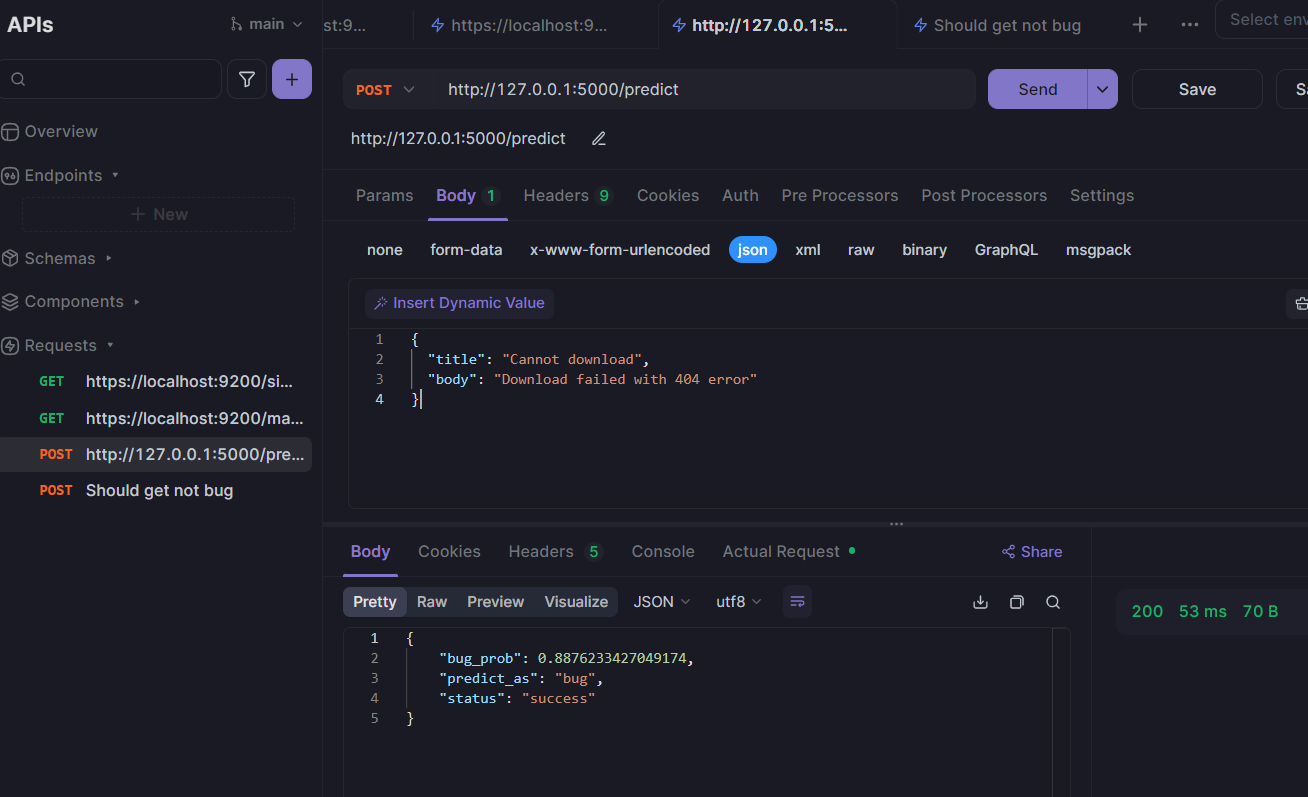

and just to show that it works

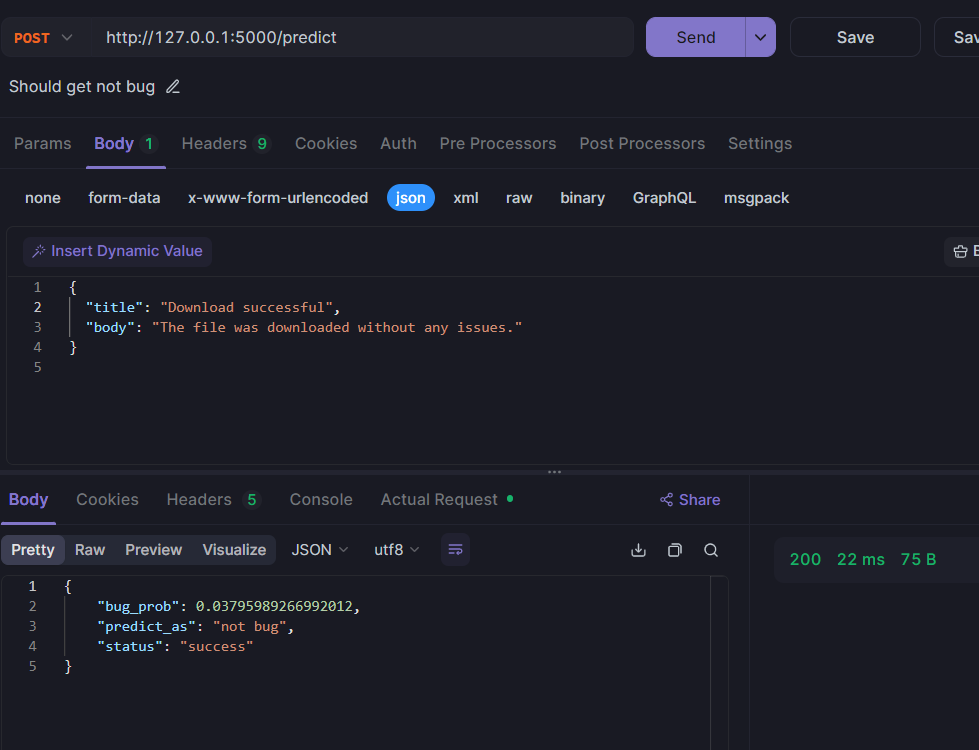